# Who Watches The Watchers?
## Towards less biased LLM judges

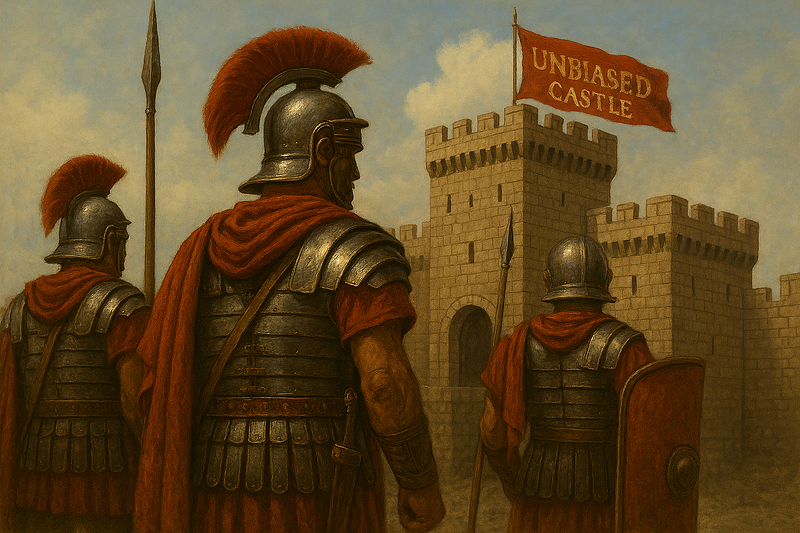

## Why LLM as a judge


- Human evaluation is the gold standard for AI system assessment but is costly and time-consuming.

- LLM-based evaluation can supplement or replace human evaluation when necessary.

- Traditional automated metrics (e.g., BLEU, ROUGE, METEOR) are efficient but miss important text qualities like coherence and creativity.

- LLMs as judges offer a balance, combining automated scalability with nuanced understanding.


## When LLM Judges Excel


- They can assess multiple criteria at once, providing structured, multi-dimensional feedback.

- LLM judges handle subjective qualities (like humour or persuasiveness) better than traditional metrics.

- They excel at comparative (pairwise) evaluation, often aligning well with human rankings.

- In specialized fields, LLM judges can be tailored for preliminary domain-specific assessments.

- They offer explainable judgments, aiding error analysis and model improvement—though overfitting to judge preferences is a risk.



# On bias in LLM judges

- LLM judges can exhibit biases similar to humans, such as positional bias, verbosity bias, and self-bias.

- Positional bias: LLMs tend to prefer the first option when presented with multiple choices.

- Verbosity bias: LLMs often favour longer, more verbose answers, even if they contain more errors.

- Self-bias: LLM judges may prefer responses generated by the same underlying model as themselves.

- Mitigation strategies include shuffling response order and scoring answers independently, though this may limit direct comparison.



- [1] https://arxiv.org/abs/2306.05685
- [2] https://www.oreilly.com/library/view/ai-engineering/9781098166298/
- [3] https://arxiv.org/abs/2307.03025
- [4] https://arxiv.org/pdf/2310.10076
- [5] https://arxiv.org/abs/2306.05685
- [6] https://journals.sagepub.com/doi/10.1177/001316446002000104
- [7] https://journals.sagepub.com/doi/10.1177/001316447303300309 


## Minimising LLM judge bias with pre-calibration - Introducing judgesync! 🧑🏼‍⚖️

Ive created a lightweight python package that helps you callibrate LLM judges: https://github.com/jasher4994/judgesync

In [48]:
from judgesync import AlignmentTracker, ScoreRange

In [49]:
# Load your evaluation data
tracker = AlignmentTracker(score_range=ScoreRange.FIVE_POINT)
tracker.load_human_scores_from_csv("sample_data.csv")

# Prompt comparison

In [50]:
prompt_comparison = tracker.create_comparison()

In [51]:
prompt_comparison.add_judge(
    name="lenient",
    system_prompt="You are a generous evaluator. Focus on the positive aspects of responses.",
)

prompt_comparison.add_judge(
    name="balanced",
    system_prompt="You are a balanced evaluator. Consider both strengths and weaknesses fairly.",
)

prompt_comparison.add_judge(
    name="Strict",
    system_prompt="You are a strict evaluator. Only give high scores to great responses.",
)

prompt_comparison.add_judge(
    name="Suyash",
    system_prompt="You are an extremely strict evaluator. Only give high scores to exceptional responses.",
)

prompt_comparison.add_judge(
    name="gpt-4o low temp",
    system_prompt="You are an extremely strict evaluator. Only give high scores to exceptional responses.",
    deployment_name="gpt-4o",
    temperature=0.3,
)

prompt_comparison.add_judge(
    name="gpt-4.1 high temp",
    system_prompt="You are an extremely strict evaluator. Only give high scores to exceptional responses.",
    deployment_name="gpt-4.1",
    temperature=0.9,
)

prompt_comparison.add_judge(
    name="James",
    system_prompt="""You are evaluating response quality on a 1-5 scale. Base your scoring on these criteria:

SCORE 5 (Excellent - Give sparingly, ~10% of responses):
- Comprehensive, accurate explanation with multiple key points
- Includes specific details, examples, or technical accuracy
- Demonstrates deep understanding of the topic
- Example: "Machine learning is when computers learn patterns from data without being explicitly programmed for every scenario. The system improves through experience. It involves algorithms that can identify patterns and make decisions."

SCORE 4 (Good - ~25% of responses):
- Accurate and mostly complete answer
- Covers main points with good clarity
- May lack some details but fundamentally correct
- Example: "Vaccines train your immune system to recognize and fight specific diseases by introducing a weakened or inactive form of the pathogen."

SCORE 3 (Average - Most common score, ~40% of responses):
- Basic correct answer that addresses the question
- Simple but accurate explanation
- Lacks depth but shows understanding
- Example: "Weather is what's happening outside right now. Climate is the average weather over many years."

SCORE 2 (Below Average - ~20% of responses):
- Overly simplified or incomplete
- Technically not wrong but missing important context
- Too brief to be useful
- Example: "Plants make food from sunlight, that's basically it."

SCORE 1 (Poor - Rarely use, ~5% of responses):
- Incorrect, misleading, or completely inadequate
- Fails to answer the question meaningfully

CRITICAL INSTRUCTIONS:
1. Most responses should score 3 (average) - this is the default for basic correct answers
2. Brief answers can still score 3 if they're accurate
3. Don't confuse brevity with poor quality - evaluate accuracy first
4. Reserve score 5 for truly comprehensive responses
5. Score 2 is for answers that are too simple to be useful, not just brief

When in doubt between scores, choose the lower one - be conservative with high scores.""",
    deployment_name="gpt-4.1",
    temperature=0.1,
)

#Prompts are appended with text relative to the point scale chosen.

python-dotenv could not parse statement starting at line 4
python-dotenv could not parse statement starting at line 4
python-dotenv could not parse statement starting at line 4
python-dotenv could not parse statement starting at line 4
python-dotenv could not parse statement starting at line 4
python-dotenv could not parse statement starting at line 4
python-dotenv could not parse statement starting at line 4


Cohen's Kappa measures agreement between two raters (in your case, humans vs LLM judge) while accounting for agreement that would happen by random chance.

κ = (Observed Agreement - Chance Agreement) / (1 - Chance Agreement)

- κ = 0.7: Your judge is production-ready
- κ = 0.5: Decent, but tune your prompts
- κ = 0.3: Needs significant improvement
- κ = 0.0: No better than random scoring

Agreement Rate = (Number of Exact Matches) / (Total Number of Items) × 100%

In [52]:
prompt_results = prompt_comparison.run_comparison(
    tracker.data_loader.items, use_async=True
)
print(prompt_results)

JUDGE COMPARISON RESULTS

Rankings by Kappa Score:
  1. James: κ=0.401, Agreement=66.0%, Correlation=0.703
  2. gpt-4.1 high temp: κ=0.248, Agreement=54.0%, Correlation=0.446
  3. gpt-4o low temp: κ=0.205, Agreement=44.0%, Correlation=0.431
  4. Strict: κ=0.200, Agreement=42.0%, Correlation=0.419
  5. Suyash: κ=0.069, Agreement=42.0%, Correlation=0.279
  6. balanced: κ=0.011, Agreement=28.0%, Correlation=0.435
  7. lenient: κ=-0.006, Agreement=8.0%, Correlation=0.265

🏆 Best Judge: James


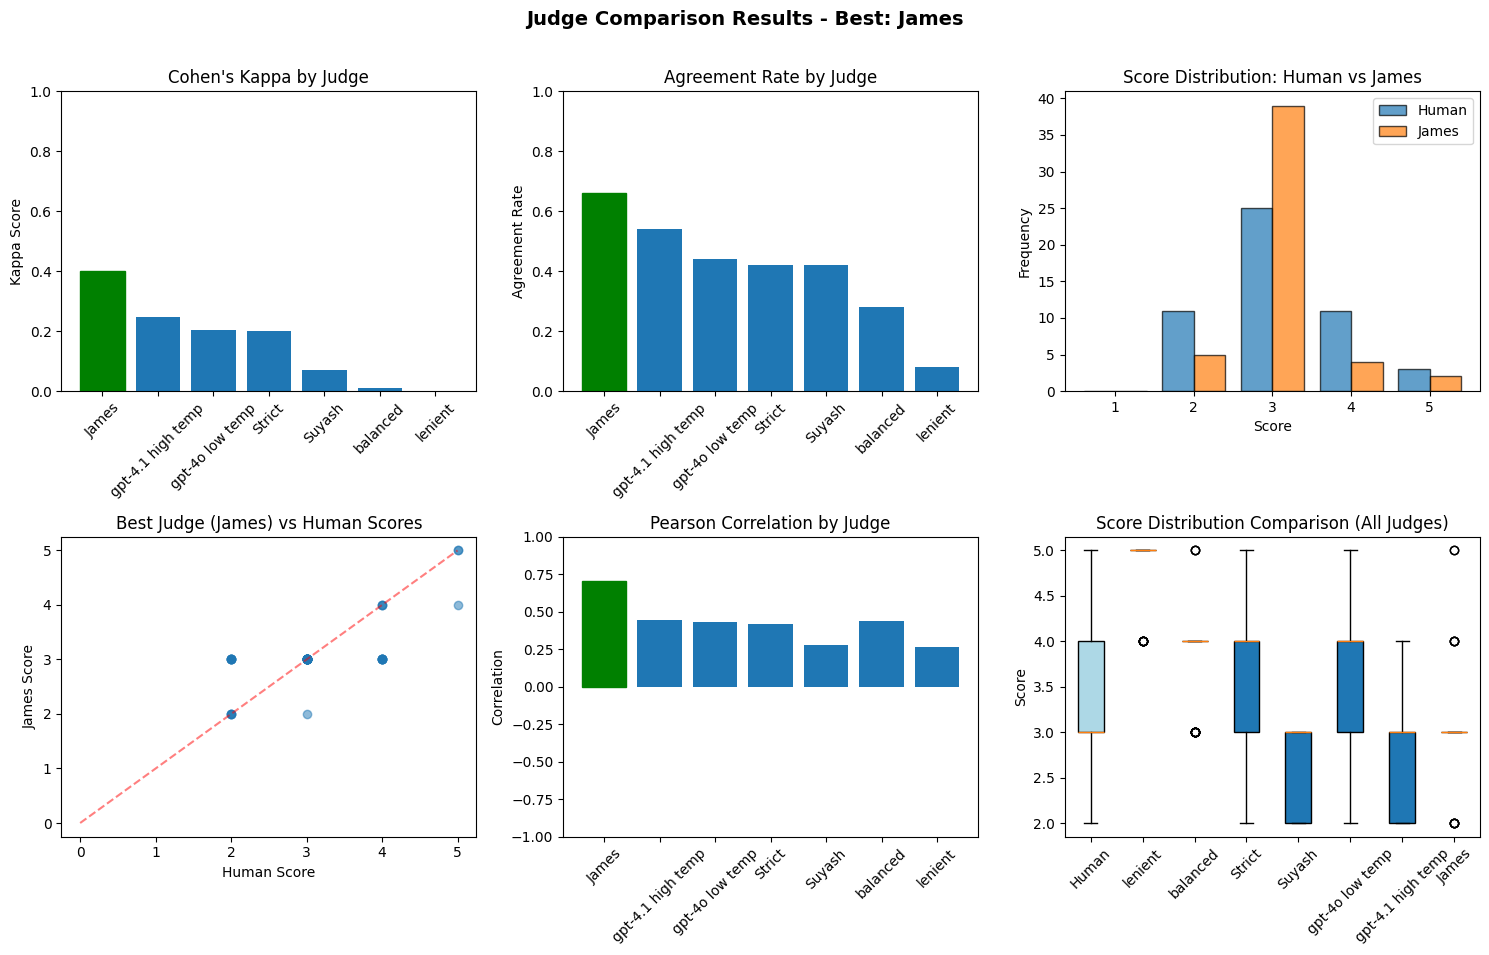

In [53]:
prompt_comparison.plot_comparison(
    prompt_results, save_path="prompt_comparison.png", show=True
)

In [54]:
disagreements = prompt_comparison.get_disagreement_items(prompt_results, threshold=1.0)
print(f"\nFound {len(disagreements)} items with high disagreement between prompts")


Found 9 items with high disagreement between prompts


In [55]:
print(disagreements)

    human_score  lenient  balanced  Strict  Suyash  gpt-4o low temp  \
2           4.0      5.0       4.0     4.0     2.0              3.0   
8           3.0      5.0       3.0     3.0     2.0              3.0   
16          3.0      5.0       4.0     5.0     3.0              5.0   
21          3.0      5.0       4.0     3.0     2.0              3.0   
25          2.0      5.0       3.0     3.0     2.0              3.0   
31          2.0      5.0       4.0     3.0     2.0              3.0   
37          3.0      5.0       4.0     4.0     2.0              3.0   
48          2.0      5.0       4.0     4.0     2.0              3.0   
49          3.0      5.0       4.0     3.0     2.0              3.0   

    gpt-4.1 high temp  James  
2                 2.0    3.0  
8                 2.0    3.0  
16                3.0    3.0  
21                2.0    3.0  
25                2.0    3.0  
31                2.0    3.0  
37                2.0    3.0  
48                2.0    3.0  
49        